In [ ]:
import os
import numpy as np
from PIL import Image
from typing import Any
from collections import defaultdict
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm.auto import tqdm

import jax
import jax.numpy as jnp

import flax
from flax import linen as nn
from flax.training import train_state, orbax_utils

import orbax
import optax

import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

In [ ]:
DATASET_PATH = "/data"
CHECKPOINT_PATH = "/tutorial_4"

print(f"{jax.devices()=}")

jax.devices()=[CpuDevice(id=0)]


In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "PreActResNet.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/PreActResNet/events.out.tfevents.preactresnet",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [ ]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data/ 255.).std(axis=(0,1,2))

In [ ]:
print(f"{DATA_MEANS=},\n{DATA_STD=}")

DATA_MEANS=array([0.49139968, 0.48215841, 0.44653091]),
DATA_STD=array([0.24703223, 0.24348513, 0.26158784])


In [ ]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    image_to_numpy
])

train_dataset = CIFAR10(DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = data.random_split(train_dataset, [45_000, 5_000], generator=torch.Generator().manual_seed(42))
_, val_set = data.random_split(val_dataset, [45_000, 5_000], generator=torch.Generator().manual_seed(42))

test_set = CIFAR10(DATASET_PATH, train=False, transform=test_transform, download=True)

train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate)
                            #    num_workers=8,
                            #    persistent_workers=True)

val_loader = data.DataLoader(val_set,
                             batch_size=128,
                             shuffle=False,
                             drop_last=False,
                             collate_fn=numpy_collate)
                            #  num_workers=4,
                            #  persistent_workers=True)

test_loader = data.DataLoader(test_set,
                              batch_size=128,
                              shuffle=False,
                              drop_last=False,
                              collate_fn=numpy_collate)
                            #   num_workers=4,
                            #   persistent_workers=True)

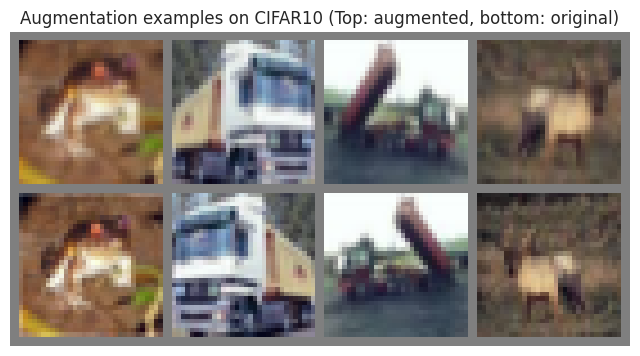

In [ ]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

imgs = np.stack(images + orig_images, axis=0)
imgs = torch.from_numpy(imgs).permute(0, 3, 1, 2)
img_grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10 (Top: augmented, bottom: original)")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [ ]:
class TrainerModule:

    def __init__(self,
                 model_name: str,
                 model_class: nn.Module,
                 model_hparams: dict,
                 optimizer_name: str,
                 optimizer_hparams: dict,
                 exmp_imgs: Any,
                 seed=42):

        super().__init__()
        self.model_name = model_name
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.seed = seed

        self.model = self.model_class(**self.model_hparams)

        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)

        self.create_functions()
        self.init_model(exmp_imgs)

    def create_functions(self):
        def calculate_loss(params, batch_stats, batch, train):
            imgs, labels = batch
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                    imgs,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)
            logits, new_model_state = outs if train else (outs, None)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, new_model_state)

        def train_step(state, batch):
            loss_fn = lambda params: calculate_loss(params, state.batch_stats, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, new_model_state = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
            return state, loss, acc

        def eval_step(state, batch):
            _, (acc, _) = calculate_loss(state.params, state.batch_stats, batch, train=False)
            return acc

        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        init_rng = jax.random.key(self.seed)
        variables = self.model.init(init_rng, exmp_imgs, train=True)
        self.init_params , self.init_batch_stats = variables['params'], variables['batch_stats']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        if self.optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif self.optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif self.optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer {self.optimizer_name.lower()}'

        lr_schedule = optax.piecewise_constant_schedule(
            init_value = self.optimizer_hparams.pop('lr'),
            boundaries_and_scales={
                int(num_steps_per_epoch*num_epochs*0.6) : 0.1,
                int(num_steps_per_epoch*num_epochs*0.85): 0.1
            }
        )

        transf = [optax.clip(1.0)]
        if opt_class == optax.sgd and 'weight_decay' in self.optimizer_hparams:
            transf.append(
                optax.add_decayed_weights(self.optimizer_hparams.pop('weight_decay'))
            )
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **self.optimizer_hparams)
        )

        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       batch_stats=self.init_batch_stats if self.state is None else self.state.batch_stats,
                                       tx = optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        self.init_optimizer(num_epochs, len(train_loader))
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        metrics = defaultdict(list)
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss, acc = self.train_step(self.state, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/' + key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        correct_class, count = 0, 0
        for batch in data_loader:
            acc = self.eval_step(self.state, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        ckpt = {
            'model': self.state
        }
        self.orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.orbax_checkpointer.save(self.log_dir + '/saved_model', ckpt, save_args)

    def load_model(self, pretrained=False):
        state_dict = self.orbax_checkpointer.restore(self.log_dir + '/saved_model')['model']
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       tx=self.state.tx if self.state else optax.sgd(0.1))

    def checkpoint_exists(self):
        return False
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))


In [ ]:
def train_classifier(*args, num_epochs=200, **kwargs):
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)

    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test':test_acc}

In [ ]:
googlenet_kernel_init = nn.initializers.kaiming_normal()

class InceptionBlock(nn.Module):
    c_red : dict
    c_out : dict
    act_fn: callable

    @nn.compact
    def __call__(self, x, train=True):
        x_1x1 = nn.Conv(self.c_out["1x1"], kernel_size=(1,1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_1x1 = nn.BatchNorm()(x_1x1, use_running_average=not train)
        x_1x1 = self.act_fn(x_1x1)

        # 3x3 convolution branch
        x_3x3 = nn.Conv(self.c_red["3x3"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)
        x_3x3 = nn.Conv(self.c_out["3x3"], kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x_3x3)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)

        # 5x5 convolution branch
        x_5x5 = nn.Conv(self.c_red["5x5"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)
        x_5x5 = nn.Conv(self.c_out["5x5"], kernel_size=(5, 5), kernel_init=googlenet_kernel_init, use_bias=False)(x_5x5)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)

        # Max-pool branch
        x_max = nn.max_pool(x, (3, 3), strides=(2, 2))
        x_max = nn.Conv(self.c_out["max"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_max = nn.BatchNorm()(x_max, use_running_average=not train)
        x_max = self.act_fn(x_max)

        x_out = jnp.concatenate([x_1x1, x_3x3, x_5x5, x_max], axis=-1)
        return x_out

In [ ]:
class GoogleNet(nn.Module):
    num_classes : int
    act_fn : callable

    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(64, kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)

        # Stacking inception blocks
        inception_blocks = [
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 32x32 => 16x16
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 16x16 => 8x8
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn)
        ]
        for block in inception_blocks:
            x = block(x, train=train) if isinstance(block, InceptionBlock) else block(x)

        # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

In [ ]:
googlenet_trainer, googlenet_results = train_classifier(model_class=GoogleNet,
                                                        model_name="GoogleNet",
                                                        model_hparams={"num_classes": 10,
                                                                       "act_fn": nn.relu},
                                                        optimizer_name="adamw",
                                                        optimizer_hparams={"lr": 1e-3,
                                                                           "weight_decay": 1e-4},
                                                        exmp_imgs=jax.device_put(
                                                            next(iter(train_loader))[0]),
                                                        num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

In [ ]:
print("GoogleNet Results", googlenet_results)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir $CHECKPOINT_PATH/tensorboards/GoogleNet/